# Game of Thrones End-To-End Notebook

This notebook contains an end-to-end workflow using a single csv file of Game of Thrones battle data.

In [1]:
import os
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.discovery import Discovery
from neo4j_runway import GraphDataModeler
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.ingestion import PyIngest

## Read Data

In [2]:
data_dictionary = load_data_dictionary_from_yaml("data_dictionary.yaml")
data_dictionary

{'name': 'The name of the battle.',
 'year': 'The year the battle took place.',
 'battle_number': 'A unique ID for the battle.',
 'king': 'A king participating in the battle.',
 'outcome': 'Whether the battle was won or lost.',
 'family': 'A significant family in the battle.',
 'size': 'The size of the army.',
 'summer': 'Whether the battle took place during Summer.',
 'location': 'The location of the battle.',
 'region': 'The larger region a battle took place in.',
 'commander': 'The commander leading an army in the battle.',
 'attacking': 'Whether the army is attacking or not.'}

In [3]:
data_directory = "../../../data/got/"
file_name = "game_of_thrones_battles.csv"
data = load_local_files(data_directory=data_directory, 
                        general_description="This file contains data on game of thrones battles", 
                        data_dictionary=data_dictionary, 
                        use_cases=["What families have changed alliances?", "how have army sizes changed over time?", "Which families attack most often?"],
                        ignored_files=["got-battles.csv", "_.ipynb"])

In [4]:
data.tables[0].dataframe

,name,year,battle_number,king,outcome,family,size,summer,location,region,commander,attacking
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Golden Tooth,The Westerlands,Jaime Lannister,True
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,True,Lannister,NaN,True,Mummer's Ford,The Riverlands,Gregor Clegane,True
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Riverrun,The Riverlands,Jaime Lannister,True
3,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Riverrun,The Riverlands,Andros Brax,True
4,Battle of the Green Fork,298,4,Robb Stark,False,Stark,18000.0,True,Green Fork,The Riverlands,Roose Bolton,True
...,...,...,...,...,...,...,...,...,...,...,...,...
179,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Stannis Baratheon,False
180,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Jon Snow,False
181,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Donal Noye,False
182,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Cotter Pyke,False


## Discovery

In [5]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini")
disc = Discovery(llm=disc_llm, data=data)

In [6]:
disc.run()

### Preliminary Analysis of Game of Thrones Battles Data

#### Overall Data Characteristics:
1. **Data Size**: The dataset contains 184 entries and 12 columns, indicating a moderate size for analysis.
2. **Data Types**: The features include a mix of categorical (object), numerical (int64, float64), and boolean data types. This diversity allows for various types of analyses.
3. **Missing Values**: There are several columns with missing values:
   - `king`: 4 missing values
   - `outcome`: 6 missing values
   - `size`: 36 missing values
   - `summer`: 3 missing values
   - `location`: 2 missing values
   - `commander`: 10 missing values
   This indicates that some battles lack complete information, particularly regarding army size and commanders.

#### Key Features for Use Cases:
1. **Families Changing Alliances**:
   - The `family` and `king` columns are crucial for analyzing alliances. The presence of multiple families and kings suggests potential shifts in alliances over battles. The `outcome` column can also provide insights into which families may have changed sides based on battle results.
   - The `commander` column can further help identify which families are leading armies and if there are any overlaps or changes in leadership.

2. **Changes in Army Sizes Over Time**:
   - The `size` column is essential for understanding army sizes, while the `year` column allows for temporal analysis. Analyzing the distribution of army sizes across different years can reveal trends in military strength and resource allocation.
   - The presence of missing values in the `size` column may affect the analysis, so it may be necessary to handle these appropriately (e.g., imputation or exclusion).

3. **Families Attacking Most Often**:
   - The `family` column can be used to count the number of battles each family has participated in. This can be complemented by the `attacking` boolean column to determine which families are on the offensive.
   - The `location` and `region` columns can provide context on where these attacks are happening, potentially revealing strategic patterns.

#### Important Features:
- **`year`**: Essential for temporal analysis of battles and army sizes.
- **`size`**: Key for understanding the scale of military engagements.
- **`family`**: Crucial for analyzing alliances and participation in battles.
- **`king`**: Important for understanding leadership and potential shifts in alliances.
- **`outcome`**: Provides insights into the success or failure of battles, which can influence future alliances.
- **`commander`**: Helps identify leadership patterns and changes over time.

#### Summary:
The dataset provides a rich source of information for analyzing battles in the Game of Thrones universe. Key features such as `family`, `size`, `year`, and `outcome` will be instrumental in addressing the use cases related to alliances, army size changes, and attack frequency. However, attention must be paid to the missing values, particularly in the `size` and `commander` columns, as they may impact the analysis.

In [7]:
disc.to_markdown(file_dir="./outputs/")

## Data Modeling

In [8]:
gdm_llm = OpenAIDataModelingLLM(model_name="gpt-4o")
gdm = GraphDataModeler(llm=gdm_llm, discovery=disc)

In [9]:
gdm.create_initial_model(max_retries=3)

Entity Pool Generation Attempt: 1
nodes : ['Battle', 'King', 'Family', 'Commander']
rels  : ['PARTICIPATED_IN', 'INVOLVED_IN', 'LED_BY', 'ATTACKED']
Received Valid Entity Pool.
validation failed
Number of Errors:  5 

Analyzing errors...
recieved a valid response


DataModel(nodes=[Node(label='Battle', properties=[Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='battleNumber', type='int', column_mapping='battle_number', alias=None, is_unique=False, part_of_key=False), Property(name='outcome', type='str', column_mapping='outcome', alias=None, is_unique=False, part_of_key=False), Property(name='size', type='int', column_mapping='size', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False), Property(name='location', type='str', column_mapping='location', alias=None, is_unique=False, part_of_key=False), Property(name='region', type='str', column_mapping='region', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='King', properties=[Property(

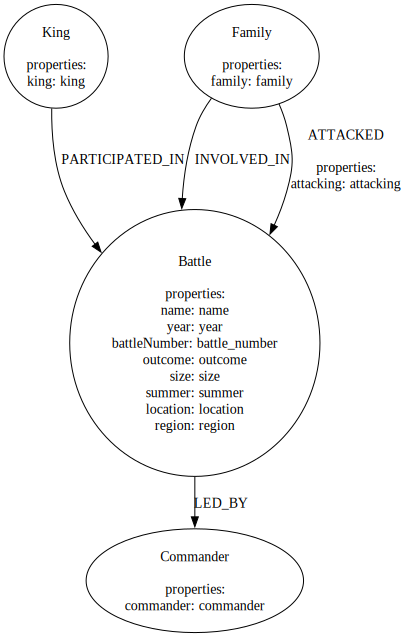

In [10]:
gdm.current_model.visualize()

In [11]:
corrections = "Create separate nodes for location and region. Add an attacking boolean property to LED_BY, PARTICPATED_IN and INVOLVED_IN. make battleNumber unique. remove the node keys."
gdm.iterate_model(corrections=corrections, max_retries=3, allow_duplicate_properties=True)

recieved a valid response


DataModel(nodes=[Node(label='Battle', properties=[Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='battleNumber', type='int', column_mapping='battle_number', alias=None, is_unique=True, part_of_key=False), Property(name='outcome', type='str', column_mapping='outcome', alias=None, is_unique=False, part_of_key=False), Property(name='size', type='int', column_mapping='size', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='King', properties=[Property(name='king', type='str', column_mapping='king', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Family', properties=[Property(name='family', type='str', column_mapping='family', alias=None, i

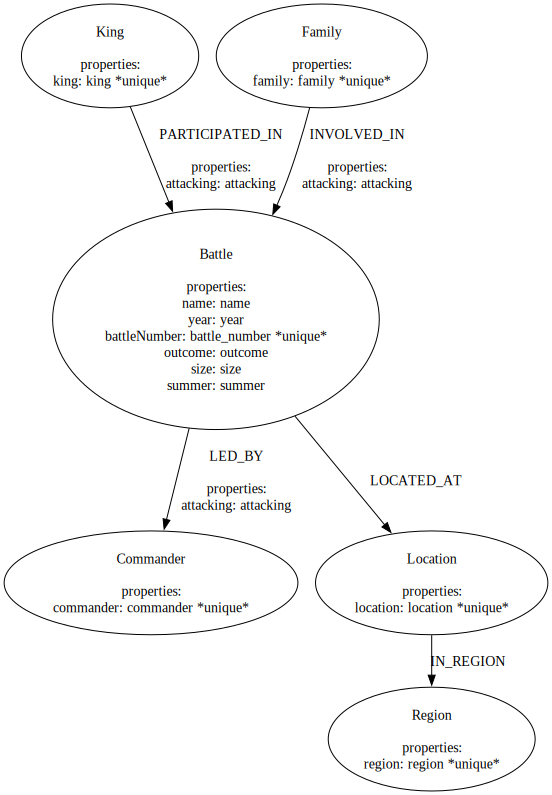

In [12]:
gdm.current_model.visualize()

## Code Generation

In [13]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, database="gameofthrones", username="neo4j", uri=os.environ.get("NEO4J_URI"), password=os.environ.get("NEO4J_PASSWORD"), source_name=file_name, file_directory=data_directory)

In [14]:
gen.generate_config_yaml(file_name="./outputs/config.yaml")

## Ingest

In [15]:
PyIngest(config=gen.generate_config_string())

File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
File {} .//../../../data/got/game_of_thrones_battles.csv
